In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import integrate as itg, constants as const
# the constants we need are `g`

In [2]:
# 初始情况
MASS_ORIGIN = 1400.0  # kg
MASS_FUEL_ORIGIN = 1080.0  # kg
FUEL_BURN_RATE = 18.0  # kg/s
PUSH_FORCE = 32000.0  # N
RESISTANCE_COEFFICIENT = 0.4  # kg/m
MASS_FINAL = MASS_ORIGIN - MASS_FUEL_ORIGIN

```{=typst}
= 分析

在 $t$ 时刻，我们有：

$
m_t = m_0 - "rate" t \
m dot(v) = F_p - m_t g - k v^2
$

初始时刻 ($t = 0$)，边界条件：

$
m = m_0 \
v = 0
$

上式中 $g$ 为重力加速度。

引擎关闭的边界条件为燃料耗尽，即 $"MASS_FUEL_FINAL" = 0$，此后推力为 0，从而：

$
m = m_0 - m_f \
m dot(v) = - m_t g - k v^2
$

最高点的边界条件为 $v = 0$。
```

In [13]:
# before the engine shuts off
# dv / dt = (PUSH_FORCE - RESISTANCE_COEFFICIENT * v^2) / (MASS_ORIGIN - FUEL_BURN_RATE * t) - g
def f1(t, v):
  """
  :param t: time
  :param v: velocity
  :return: dv / dt
  """
  return (PUSH_FORCE - RESISTANCE_COEFFICIENT * v**2) / (MASS_ORIGIN - FUEL_BURN_RATE * t) - const.g


# the range of t (in this stage) is `0` to `MASS_FUEL_ORIGIN / FUEL_BURN_RATE`
t_interval = MASS_FUEL_ORIGIN / FUEL_BURN_RATE
# 0.0 is the initial velocity
res1 = itg.solve_ivp(f1, (0.0, t_interval), [0.0], dense_output=True, method='RK45')  # RK45 is the fault method

# we can get the max velocity by res1.sol(t_interval_1)
v_max = res1.sol(t_interval)[0]
a = f1(t_interval, v_max)

# the height at t = t_interval_1
h_f1 = itg.quad(res1.sol, 0.0, t_interval)[0]

# for plot
t_1 = np.linspace(0, int(t_interval), int(t_interval) * 100 + 1)
h_1 = np.array([itg.quad(res1.sol, 0.0, t)[0] for t in t_1])
a_1 = np.array(f1(t_1, res1.sol(t_1)[0]))

In [12]:
# after the engine shuts off, the mass is a constant
# dv / dt = - RESISTANCE_COEFFICIENT * v^2 / MASS_FINAL - g


def f2(t, v):
  """
  :param t: time
  :param v: velocity
  :return: dv / dt
  """
  return -RESISTANCE_COEFFICIENT * v**2 / MASS_FINAL - const.g


res2 = itg.solve_ivp(f2, (t_interval, 1000), [v_max], dense_output=True, method='RK45')

a_p = f2(t_interval, v_max)
a_final = const.g

t_2 = np.linspace(int(t_interval), 1000, 1001)


def get_t_final():
  for t in t_2:
    if res2.sol(t)[0] < 0:
      return t
  print('Error: t_final not found')
  return None


t_final = get_t_final()
t_2_new = np.linspace(int(t_interval), int(t_final), 1001)
h_2 = np.array([itg.quad(res2.sol, t_interval, t)[0] + h_f1 for t in t_2_new])
a_2 = np.array(f2(t_2_new, res2.sol(t_2_new)[0]))
h_f2 = h_2[-1]

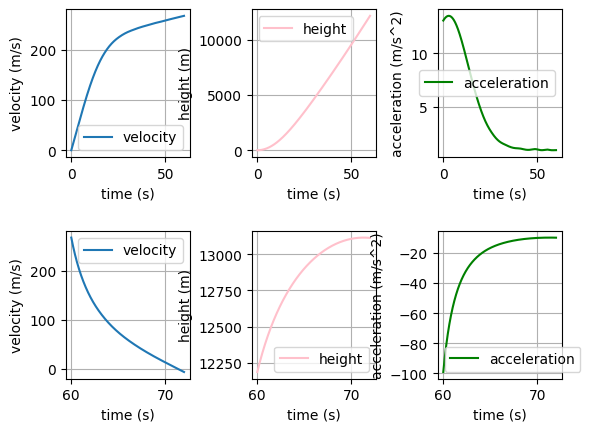

In [14]:
# plot
plt.figure()
plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.5)

plt.subplot(2, 3, 1)
plt.plot(t_1, res1.sol(t_1)[0], label='velocity')
plt.grid()
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('velocity (m/s)')

plt.subplot(2, 3, 2)
plt.plot(t_1, h_1, label='height', color='pink')
plt.grid()
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('height (m)')

plt.subplot(2, 3, 3)
plt.plot(t_1, a_1, label='acceleration', color='green')
plt.grid()
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('acceleration (m/s^2)')

plt.subplot(2, 3, 4)
plt.plot(t_2_new, res2.sol(t_2_new)[0], label='velocity')
plt.grid()
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('velocity (m/s)')

plt.subplot(2, 3, 5)
plt.plot(t_2_new, h_2, label='height', color='pink')
plt.grid()
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('height (m)')

plt.subplot(2, 3, 6)
plt.plot(t_2_new, a_2, label='acceleration', color='green')
plt.grid()
plt.legend()
plt.xlabel('time (s)')
plt.ylabel('acceleration (m/s^2)')

plt.show()

# result

引擎关闭时：

- 高度：12187.48m
- 速度：267.23m/s
- 加速度：0.93m/s^2(向下) -> -99.07m/s^2(向下)

最高点：

- 高度：13111.68m
- 加速度：-9.81m/s^2(向下)